# Stationary Or Not

In universe of signals we have two groups:
- Stationary Signal
- Non-Stationary Signal

## Why do we bother whether a signal is stationary or not ?
In my understanding, the main objective is **Predictability**. If a signal is stationary, we know that this signal is having some "fix"(=stationary?) properties, ie. Mean, Min, Max, Deviation or Distribution. Knowing a signal is stationary doesn't mean it is more predictable, a stationary signal with wider deviation is less predictable.

When we know a signal is stationary, we could go with further analysis or modelling.

And, when we know a signal is not stationary, we will try to transform it first to become stationary.

## What is the simplest stationary signal ?

My answer is Nothing.

It is a nothing signal and we add a white noise signal on it. Then, we are interested in properties of this white noise.

I would like to think to group stationary signals into two:
1. Nothing
1. Periodic Signal.
    - We can start talking about sinusoidal and autocorrelation from here.


Related topic:
- https://en.wikipedia.org/wiki/Randomness
- https://en.wikipedia.org/wiki/Ljung%E2%80%93Box_test

## Can we predict a stationary signal ?

Assuming we are talking about Stochastic signal, the simple answer is NO.

But, knowing a signal is stationary at least we have understanding what is the best guess and its deviation out of the uncertainty. And also there are some available tools to extract other statistical properties.

## How to transform a non into stationary Signal ?

We will try to answer by using the reverse direction: how to transform a Stationary into a Non Stationary Signal ?

#### Adding Trend
Either linear or polynomial. If this polynomial is having finite order, we could get its derivatives until to a constant.

Hence, we could start the transformation by calculating first difference, second, third etc.

Noted! A sinusional-like signals are having infinite derivatives.

#### Adding Exponential ???

## Now, let's start working.

Following code is a complementary effort to BennyLP's codes/notes in [Stationarity](https://github.com/bennylp/Study/blob/master/Introduction%20to%20Time%20Series%20Analysis%20with%20Python/Stationarity.ipynb)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.stattools import coint, adfuller, kpss
import statsmodels.tsa.api as smt
import statsmodels.stats.diagnostic
from IPython.display import display, Markdown, HTML

N = 200
WSCALE = 0.001
MAXLAGS = 100

In [2]:
def staplot(name, y, figsize=(15, 6), lags=MAXLAGS, style='bmh', ylim=None, useKpss=False):
    CRIT = 0.01
    adres = adfuller(y)
    
    df = pd.DataFrame()
    pval = adres[1]
    df.loc['AdFuller', 'Decision'] = decision = 'Stationary' if pval < CRIT else 'NOT Stationary'
    df.loc['AdFuller', 'Reason'] = 'pvalue: %.4f' % pval
    
    tval = adres[0]
    tlim = adres[4]['%d%%' % (CRIT / 0.01)]
    trel = '<' if tval < tlim else '>='
    df.loc['AdFuller t-value', 'Decision'] = 'Stationary' if tval < tlim else 'NOT Stationary'
    df.loc['AdFuller t-value', 'Reason'] = 'tvalue %.1f %s %.1f' % (tval, trel, tlim)
    
    if useKpss:
        kres = kpss(y, regression='c')
        pval = kres[1]
        df.loc['KPSS', 'Decision'] = 'NOT Stationary' if pval < CRIT else 'Stationary'
        df.loc['KPSS', 'Reason'] = 'pvalue: %.4f' % pval

        if df.loc['AdFuller', 'Decision'] == 'Stationary':
            if df.loc['KPSS', 'Decision'] == 'Stationary':
                decision = 'Stationary'
            else:
                decision = 'Difference Stationary'
        else:
            if df.loc['KPSS', 'Decision'] == 'Stationary':
                decision = 'Trend Stationary'
            else:
                decision = 'NOT Stationary'
        
    display(HTML(df.to_html()))        
    
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0), colspan=2)
        #pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        ts_ax.plot(y, label=name, color='C0')
        ts_ax.set_title('%s: %s' %  (name, decision))
        if ylim: ts_ax.set_ylim(ylim)
        ts_ax.legend()

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        #smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        
        plt.tight_layout()

Some procedures to check signals.

In [3]:
def checkRandomNormal( y ):
    describe = stats.describe( y )
    df = pd.DataFrame()
    df.loc["nobs", "value"] = "%d" % describe.nobs
    df.loc["min", "value"] = "%.5f" % describe.minmax[0]
    df.loc["mean", "value"] = "%.5f" % describe.mean
    df.loc["max", "value"] = "%.5f" % describe.minmax[1]
    df.loc["variance", "value"] = "%.5f" % describe.variance
    df.loc["std", "value"] = "%.5f" % np.sqrt( describe.variance )
    df.loc["skewness", "value"] = "%.5f" % describe.skewness
    df.loc["kurtosis", "value"] = "%.5f" % describe.kurtosis
    
    return df

def checkLinearRegression( x, y ):
    fy = stats.linregress( x, y )
    y_trend = x * fy.slope + fy.intercept
    describe = stats.describe( y-y_trend )

    df = pd.DataFrame()
    df.loc["slope", "value"] = "%.5f" % fy.slope
    df.loc["intercept", "value"] = "%.5f" % fy.intercept
    df.loc["rvalue", "value"] = "%.5f" % fy.rvalue
    df.loc["pvalue", "value"] = "%.5f" % fy.pvalue
    df.loc["stderr", "value"] = "%.5f" % fy.stderr
    
    describe = stats.describe( y )
    df.loc["noise-nobs", "value"] = "%d" % describe.nobs
    df.loc["noise-min", "value"] = "%.5f" % describe.minmax[0]
    df.loc["noise-mean", "value"] = "%.5f" % describe.mean
    df.loc["noise-max", "value"] = "%.5f" % describe.minmax[1]
    df.loc["noise-variance", "value"] = "%.5f" % describe.variance
    df.loc["noise-std", "value"] = "%.5f" % np.sqrt( describe.variance )
    df.loc["noise-skewness", "value"] = "%.5f" % describe.skewness
    df.loc["noise-kurtosis", "value"] = "%.5f" % describe.kurtosis
    
    df.loc[:,"interpretation"] = ""
    if fy.pvalue<0.05:
        df.loc["pvalue", "interpretation"] = "Reject null hypothesis that the slope is zero"
    else:
        df.loc["pvalue", "interpretation"] = "Accept null hypothesis that the slope is zero"
    return df

## White Noise
### Sample 1

,Decision,Reason
AdFuller,Stationary,pvalue: 0.0000
AdFuller t-value,Stationary,tvalue -15.2 < -3.5


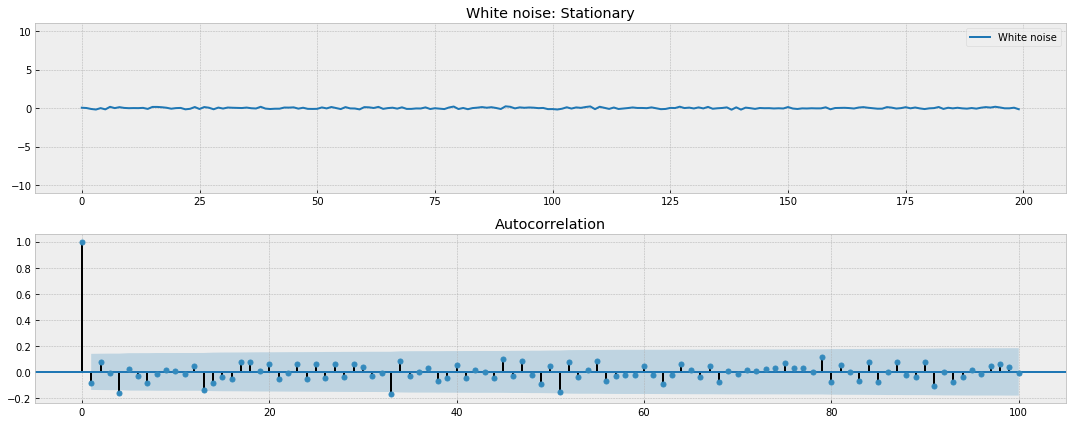

In [4]:
y = np.random.normal(scale=0.1, size=N)
staplot('White noise', y, ylim=[-11, 11])

,value
nobs,200
min,-0.21379
mean,-0.00291
max,0.22490
variance,0.00880
std,0.09381
skewness,0.06109
kurtosis,-0.65402


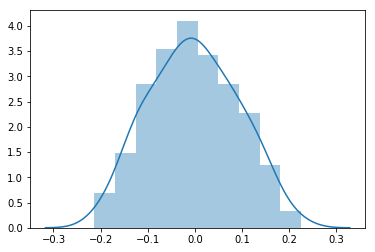

In [5]:
display(checkRandomNormal( y ))
sns.distplot(y)

In [6]:
# Check randomness
z = statsmodels.stats.diagnostic.acorr_ljungbox( y )
print( np.where( z[1] < 0.05 )[0] )

[]


#### Interpretations
The more output count, the less random signal.

There are some suggestions on a _good_ lag length (by default is 40):
- https://stats.stackexchange.com/questions/200267/interpreting-ljung-box-test-results-from-statsmodels-stats-diagnostic-acorr-lju
- https://robjhyndman.com/hyndsight/ljung-box-test/
- https://support.numxl.com/hc/en-us/articles/115001099806-How-do-I-test-whether-a-given-time-series-is-just-white-noise-

### White Noise - Sample 2

,Decision,Reason
AdFuller,Stationary,pvalue: 0.0000
AdFuller t-value,Stationary,tvalue -14.9 < -3.5


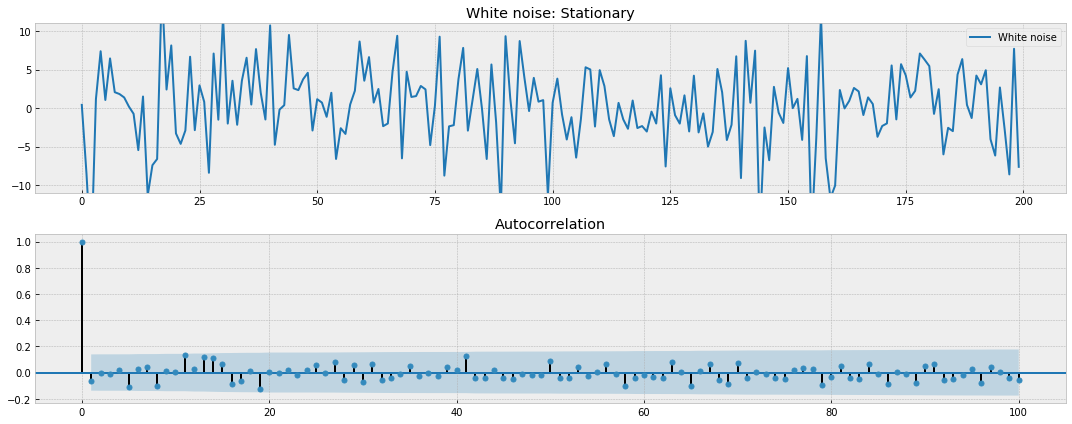

In [7]:
y = np.random.normal(scale=5, size=N)
staplot('White noise', y, ylim=[-11, 11])

,value
nobs,200
min,-19.42945
mean,0.20896
max,15.75663
variance,28.97114
std,5.38248
skewness,-0.44460
kurtosis,1.03176


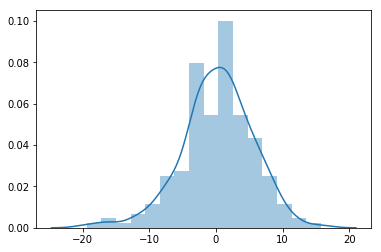

In [8]:
display(checkRandomNormal( y ))
sns.distplot(y)

### White Noise - Sample 3

,Decision,Reason
AdFuller,Stationary,pvalue: 0.0000
AdFuller t-value,Stationary,tvalue -13.6 < -3.5


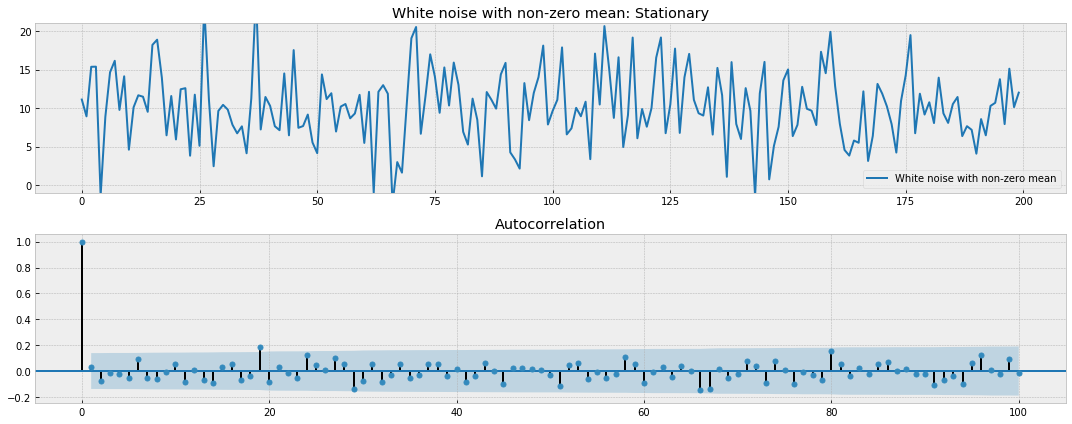

In [9]:
y = 10 + np.random.normal(scale=5, size=N)
staplot('White noise with non-zero mean', y, ylim=[-1, 21])

,value
nobs,200
min,-2.47594
mean,10.22994
max,24.78060
variance,22.58982
std,4.75287
skewness,0.12671
kurtosis,0.23653


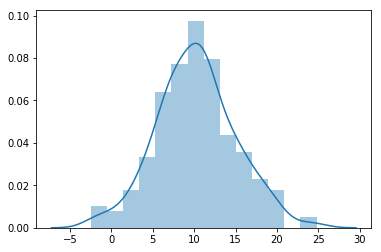

In [10]:
display(checkRandomNormal( y ))
sns.distplot(y)

## Lines

In [11]:
def generateLine(n=N, slope=1, wscale=WSCALE):
    w = np.random.normal(scale=wscale, size=n)
    if slope:
        return np.arange(0, n*slope, slope) + w
    else:
        return w

### Lines - Sample 1

,Decision,Reason
AdFuller,NOT Stationary,pvalue: 0.9774
AdFuller t-value,NOT Stationary,tvalue 0.3 >= -3.5


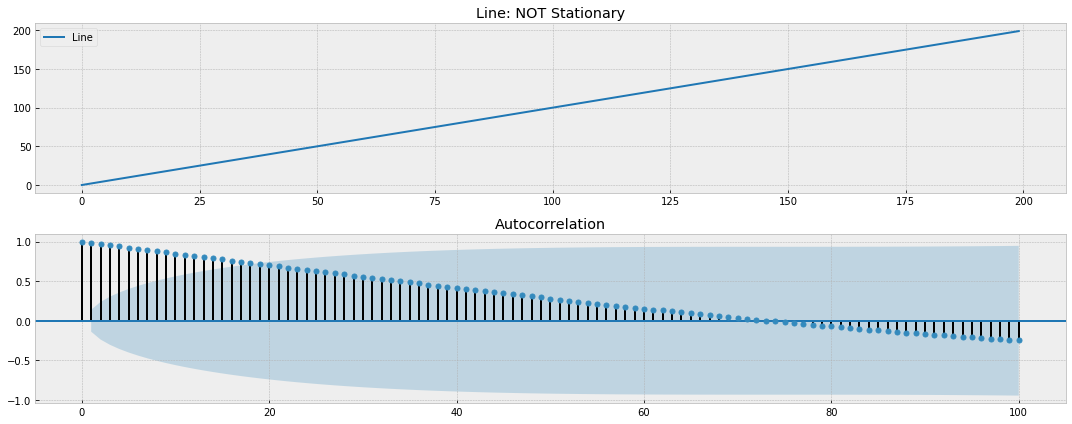

In [12]:
y = generateLine()
staplot('Line', y)

In [13]:
display(checkRandomNormal( y ))
x = np.arange( 0, N )
display(checkLinearRegression( x, y ))

,value
nobs,200
min,0.00013
mean,99.49984
max,199.00069
variance,3350.00286
std,57.87921
skewness,0.00000
kurtosis,-1.20006


,value,interpretation
slope,1.00000,
intercept,-0.00020,
rvalue,1.00000,
pvalue,0.00000,Reject null hypothesis that the slope is zero
stderr,0.00000,
noise-nobs,200,
noise-min,0.00013,
noise-mean,99.49984,
noise-max,199.00069,
noise-variance,3350.00286,


### Lines - Sample 2

,Decision,Reason
AdFuller,Stationary,pvalue: 0.0000
AdFuller t-value,Stationary,tvalue -13.2 < -3.5


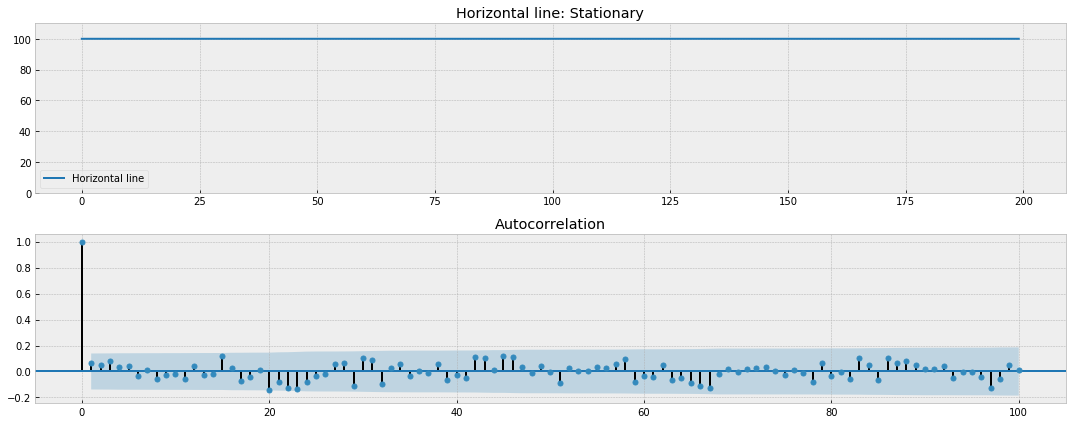

In [14]:
y = 100 + generateLine(slope=0)
staplot('Horizontal line', y, ylim=[0,110])

In [15]:
x = np.arange( 0, N )
display( checkLinearRegression( x, y ))

,value,interpretation
slope,-0.00000,
intercept,100.00027,
rvalue,-0.10042,
pvalue,0.15714,Accept null hypothesis that the slope is zero
stderr,0.00000,
noise-nobs,200,
noise-min,99.99704,
noise-mean,100.00010,
noise-max,100.00234,
noise-variance,0.00000,


### Lines - Sample 3

,Decision,Reason
AdFuller,NOT Stationary,pvalue: 0.1334
AdFuller t-value,NOT Stationary,tvalue -2.4 >= -3.5


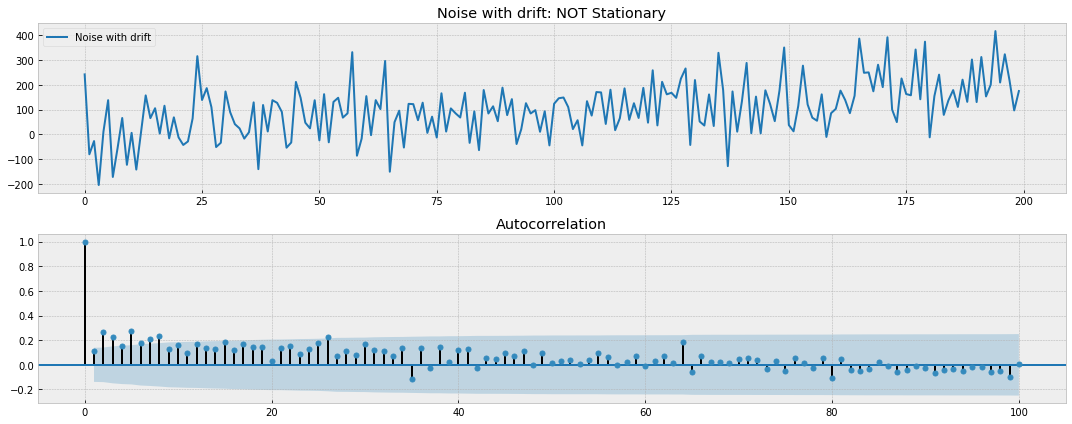

In [16]:
y = generateLine(slope=1, wscale=100)
staplot('Noise with drift', y)

In [17]:
x = np.arange( 0, N )
display( checkLinearRegression( x, y ))

,value,interpretation
slope,0.92544,
intercept,11.25594,
rvalue,0.47674,
pvalue,0.00000,Reject null hypothesis that the slope is zero
stderr,0.12127,
noise-nobs,200,
noise-min,-204.21039,
noise-mean,103.33718,
noise-max,416.85176,
noise-variance,12623.22182,


## Random Walk

In [18]:
def generateRandomWalk(n=N, seed=1):
    np.random.seed(seed)

    x = w = np.random.normal(scale=1, size=n)
    for t in range(n):
        x[t] = x[t-1] + w[t]
    return x

### Random Walk - Sample 1

,Decision,Reason
AdFuller,NOT Stationary,pvalue: 0.9965
AdFuller t-value,NOT Stationary,tvalue 1.3 >= -3.5


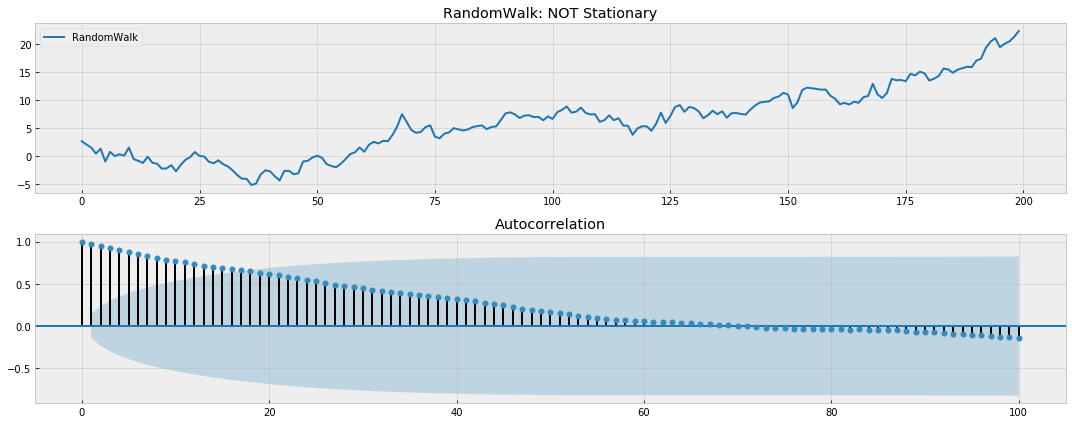

In [19]:
y = generateRandomWalk(seed=1)
staplot('RandomWalk', y)

In [20]:
x = np.arange( 0, N )
display( checkLinearRegression( x, y ))

,value,interpretation
slope,0.09870,
intercept,-3.76423,
rvalue,0.92721,
pvalue,0.00000,Reject null hypothesis that the slope is zero
stderr,0.00283,
noise-nobs,200,
noise-min,-5.17574,
noise-mean,6.05630,
noise-max,22.38221,
noise-variance,37.95901,


## AR(1) Process

In [21]:
def generateAR1(rho, n=N, seed=1):
    np.random.seed(seed)

    y = w = np.random.normal(scale=1, size=n)
    for t in range(n):
        y[t] = rho * y[t-1] + w[t]
    return y

### p = 0.9

,Decision,Reason
AdFuller,Stationary,pvalue: 0.0034
AdFuller t-value,Stationary,tvalue -3.8 < -3.5


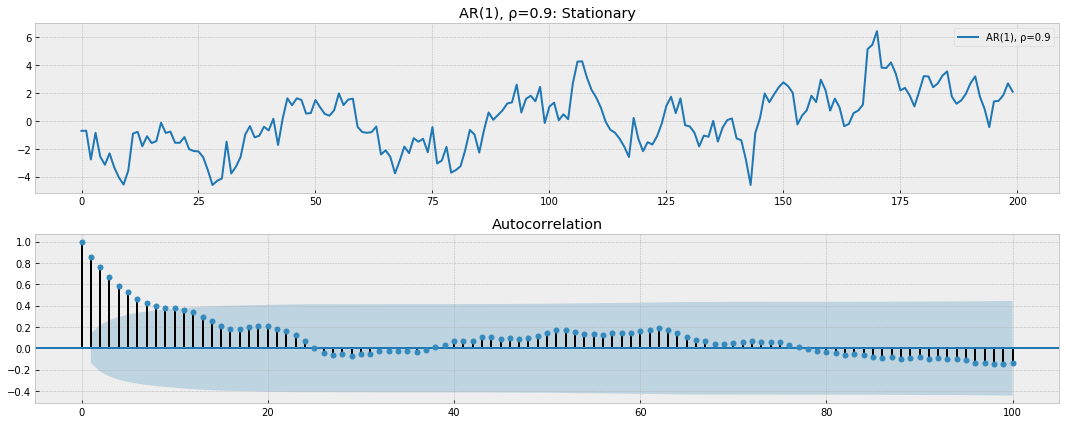

In [22]:
rho = 0.9
y = generateAR1(rho, seed=2)
staplot('AR(1), ρ=%.1f' % rho, y)

In [23]:
import statsmodels.tsa.stattools
import statsmodels.tsa.arima_model

mod = statsmodels.tsa.arima_model.ARMA(y, order=(1,0))
result = mod.fit()
print('mu=%f, phi=%f' % (result.params[0], result.params[1]))
print(result.summary())

mu=0.052606, phi=0.860224
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  200
Model:                     ARMA(1, 0)   Log Likelihood                -299.356
Method:                       css-mle   S.D. of innovations              1.077
Date:                Tue, 29 Jan 2019   AIC                            604.713
Time:                        06:45:09   BIC                            614.608
Sample:                             0   HQIC                           608.717
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0526      0.529      0.099      0.921      -0.984       1.090
ar.L1.y        0.8602      0.035     24.338      0.000       0.791       0.929
                          

## p = -0.9

,Decision,Reason
AdFuller,Stationary,pvalue: 0.0000
AdFuller t-value,Stationary,tvalue -9.7 < -3.5


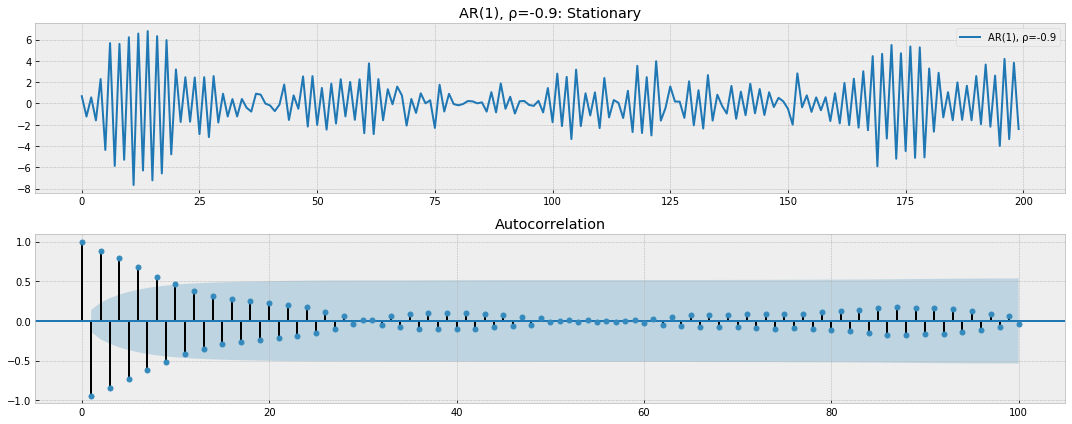

In [24]:
rho = -0.9
y = generateAR1(rho, seed=1)
staplot('AR(1), ρ=%.1f' % rho, y)

In [25]:
mod = statsmodels.tsa.arima_model.ARMA(y, order=(1,0))
result = mod.fit()
print('mu=%f, phi=%f' % (result.params[0], result.params[1]))
print(result.summary())

mu=0.052406, phi=-0.940468
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  200
Model:                     ARMA(1, 0)   Log Likelihood                -262.871
Method:                       css-mle   S.D. of innovations              0.896
Date:                Tue, 29 Jan 2019   AIC                            531.742
Time:                        06:45:09   BIC                            541.637
Sample:                             0   HQIC                           535.746
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0524      0.033      1.601      0.111      -0.012       0.117
ar.L1.y       -0.9405      0.023    -41.372      0.000      -0.985      -0.896
                         

## MA(1) Process

In [26]:
def generateMA(theta, n=N, mu=0, seed=1):
    np.random.seed(seed)

    y = w = np.random.normal(scale=1, size=n)
    y[0] = mu
    for t in range(1, n):
        y[t] = mu + w[t] + theta * w[t-1]
    return y

,Decision,Reason
AdFuller,Stationary,pvalue: 0.0028
AdFuller t-value,Stationary,tvalue -3.8 < -3.5


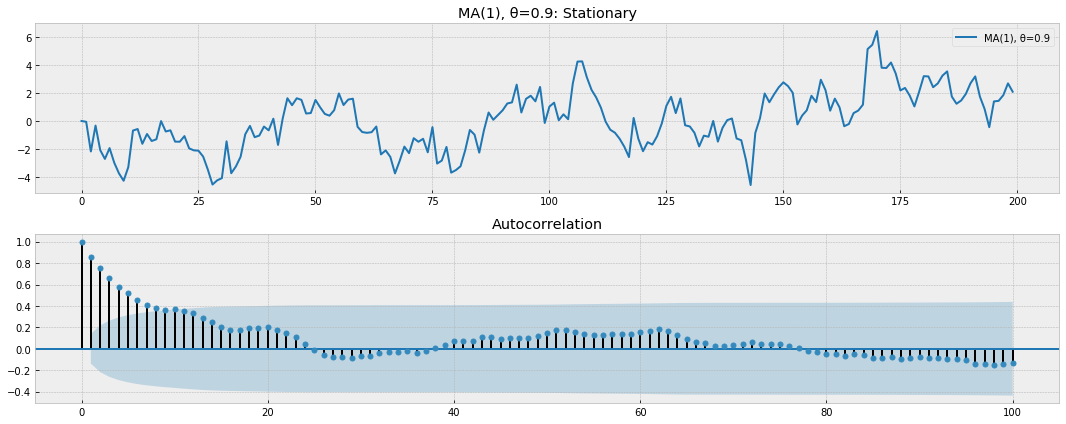

In [27]:
theta = 0.9
y = generateMA(theta, seed=2)
staplot('MA(1), θ=%.1f' % theta, y)

In [28]:
mod = statsmodels.tsa.arima_model.ARMA(y, order=(1,0))
result = mod.fit()
print('mu=%f, phi=%f' % (result.params[0], result.params[1]))
print(result.summary())

mu=0.104902, phi=0.855828
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  200
Model:                     ARMA(1, 0)   Log Likelihood                -299.176
Method:                       css-mle   S.D. of innovations              1.076
Date:                Tue, 29 Jan 2019   AIC                            604.353
Time:                        06:45:10   BIC                            614.247
Sample:                             0   HQIC                           608.357
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1049      0.513      0.204      0.838      -0.901       1.111
ar.L1.y        0.8558      0.036     23.878      0.000       0.786       0.926
                          